In [6]:
import numpy as np
import pandas as pd 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
import torch
import cv2
import glob
import os
import shutil
import random
import warnings as wr

wr.filterwarnings("ignore")

In [7]:
!pip install ultralytics

In [31]:
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

In [49]:
model = YOLO('yolov8n.pt')

## Data Preparation

In [10]:
train_path=r'../input/pedestrian-detection/Train/Train/JPEGImages'
train_annot=r'../input/pedestrian-detection/Train/Train/Annotations'

test_path=r'../input/pedestrian-detection/Test/Test/JPEGImages'
test_annot=r'../input/pedestrian-detection/Test/Test/Annotations'

val_path=r'../input/pedestrian-detection/Val/Val/JPEGImages'
val_annot=r'../input/pedestrian-detection/Val/Val/Annotations'

In [11]:
classes = {'person': 0, 'person-like': 1}

In [12]:
def get_image_size(image_path):
    img = cv2.imread(image_path)
    height, width, _ = img.shape
    return width, height

In [13]:
def creatingInfoData(Annotpath):
    information={'xmin':[],'ymin':[],'xmax':[],'ymax':[],'ymax':[],'name':[]
                ,'label':[], 'width':[], 'height':[]}

    for file in sorted(glob.glob(str(Annotpath+'/*.xml*'))):
        dat=ET.parse(file)
        for element in dat.iter():    

            if 'object'==element.tag:
                for attribute in list(element):
                    if 'name' in attribute.tag:
                        name = attribute.text                 
                        information['label'] += [name]
                        img_name = [file.split('/')[-1][0:-4]]
                        information['name'] += img_name
                                                
                        image_size = get_image_size(f"{Annotpath[:-11]}JPEGImages/{img_name[0]}.jpg")
                        information['width'].append(image_size[0])
                        information['height'].append(image_size[1])

                    if 'bndbox'==attribute.tag:
                        for dim in list(attribute):
                            if 'xmin'==dim.tag:
                                xmin=int(round(float(dim.text)))
                                information['xmin']+=[xmin]
                            if 'ymin'==dim.tag:
                                ymin=int(round(float(dim.text)))
                                information['ymin']+=[ymin]
                            if 'xmax'==dim.tag:
                                xmax=int(round(float(dim.text)))
                                information['xmax']+=[xmax]
                            if 'ymax'==dim.tag:
                                ymax=int(round(float(dim.text)))
                                information['ymax']+=[ymax]
                     
    return pd.DataFrame(information)

In [14]:
train_info=creatingInfoData(train_annot)
test_info=creatingInfoData(test_annot)
val_info=creatingInfoData(val_annot)

In [15]:
def convert_to_yolo(xmin, ymin, xmax, ymax, img_width, img_height, class_id):
    # Calculate bounding box center
    x_center = (xmin + xmax) / 2.0
    y_center = (ymin + ymax) / 2.0
    
    # Normalize bounding box coordinates
    x_center /= img_width
    y_center /= img_height
    box_width = (xmax - xmin) / img_width
    box_height = (ymax - ymin) / img_height
    
    # YOLO format: <object-class> <x> <y> <width> <height>
    return f"{class_id} {x_center} {y_center} {box_width} {box_height}\n"

In [16]:
def save_yolo_annotations(df, dest_path):
    for name, group in df.groupby('name'):
        with open(os.path.join(dest_path, name + '.txt'), 'w') as f:
            for _, row in group.iterrows():
                yolo_format = convert_to_yolo(
                    row['xmin'], row['ymin'], row['xmax'], row['ymax'],
                    row['width'], row['height'], classes[row['label']])
                f.write(yolo_format)

In [17]:
base_dest = '/kaggle/working/yolov8'
train_dest = os.path.join(base_dest, 'train')
test_dest = os.path.join(base_dest, 'test')
val_dest = os.path.join(base_dest, 'val')

# Create the directory structure if it doesn't exist
for path in [train_dest, test_dest, val_dest]:
    images_dir = os.path.join(path, 'images')
    labels_dir = os.path.join(path, 'labels')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

# Copy images
shutil.copytree(train_path, os.path.join(train_dest, 'images'), dirs_exist_ok=True)
shutil.copytree(val_path, os.path.join(val_dest, 'images'), dirs_exist_ok=True)
shutil.copytree(test_path, os.path.join(test_dest, 'images'), dirs_exist_ok=True)


'/kaggle/working/yolov8/test/images'

In [18]:
save_yolo_annotations(train_info, os.path.join(train_dest, 'labels'))
save_yolo_annotations(test_info, os.path.join(test_dest, 'labels'))
save_yolo_annotations(val_info, os.path.join(val_dest, 'labels'))

In [19]:
train_info.head(20)

,xmin,ymin,xmax,ymax,name,label,width,height
0,158,44,289,167,image (1),person,500,442
1,185,56,287,241,image (10),person,500,332
2,2,86,344,374,image (100),person,500,374
3,220,95,500,290,image (100),person,500,374
4,13,110,213,375,image (101),person,500,375
5,149,127,355,375,image (101),person,500,375
6,292,61,500,375,image (101),person,500,375
7,1,19,335,338,image (102),person,500,338
8,261,23,500,338,image (102),person,500,338
9,77,46,202,464,image (103),person,367,500


In [20]:
train_info.loc[train_info['name']=='image (152)']

,xmin,ymin,xmax,ymax,name,label,width,height
126,217,101,453,333,image (152),person,500,333
127,1,7,282,333,image (152),person,500,333


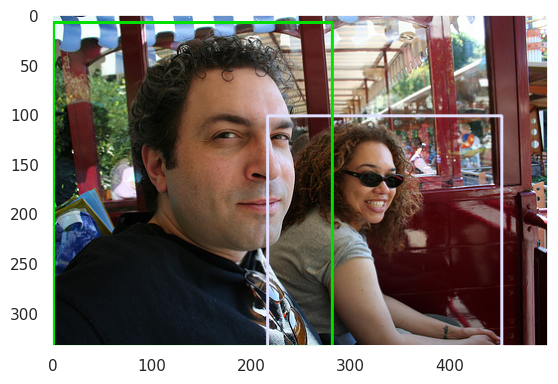

In [21]:
img=cv2.imread(train_path+'/image (152).jpg',cv2.IMREAD_COLOR)
img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)

cv2.rectangle(img,(217,101),(453,333),(225,225,255),2)
cv2.rectangle(img,(1,7),(282,333),(0,225,0),2)

plt.imshow(img)

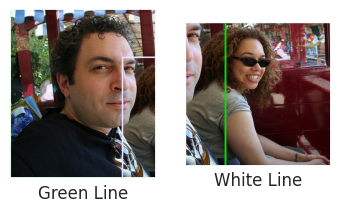

In [22]:
#  [y-min:y-max,x-min:x-max]
fig=plt.figure()

plt.subplot(1,3,1)
plt.imshow(img[7:333,1:282])
plt.xticks([])
plt.yticks([])
plt.xlabel('Green Line')

plt.subplot(1,3,2)
plt.imshow(img[101:333,217:453])
plt.xticks([])
plt.yticks([])
plt.xlabel('White Line')


plt.show()

### Splitting Objects

In [23]:
def croppingFromImage(path,Data_information):
    cropped_image=[]
    label=[]
    for i in range(0,len(Data_information)):
        img=cv2.imread(path+'/'+Data_information['name'][i]+'.jpg',cv2.IMREAD_COLOR)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_=img[Data_information['ymin'][i]:Data_information['ymax'][i],Data_information['xmin'][i]:Data_information['xmax'][i]]
        cropped_image.append(img_)
        
        label.append(Data_information['label'][i])
    return cropped_image , label

In [24]:
trainImage, trainLabel = croppingFromImage(train_path,train_info)
testImage, testLabel = croppingFromImage(test_path,test_info)

valImage, valLabel = croppingFromImage(val_path,val_info)

In [25]:
print(len(trainImage) == len(trainLabel))
print(len(testImage) == len(testLabel))
print(len(valImage) == len(valLabel))

True
True
True


### Training Data

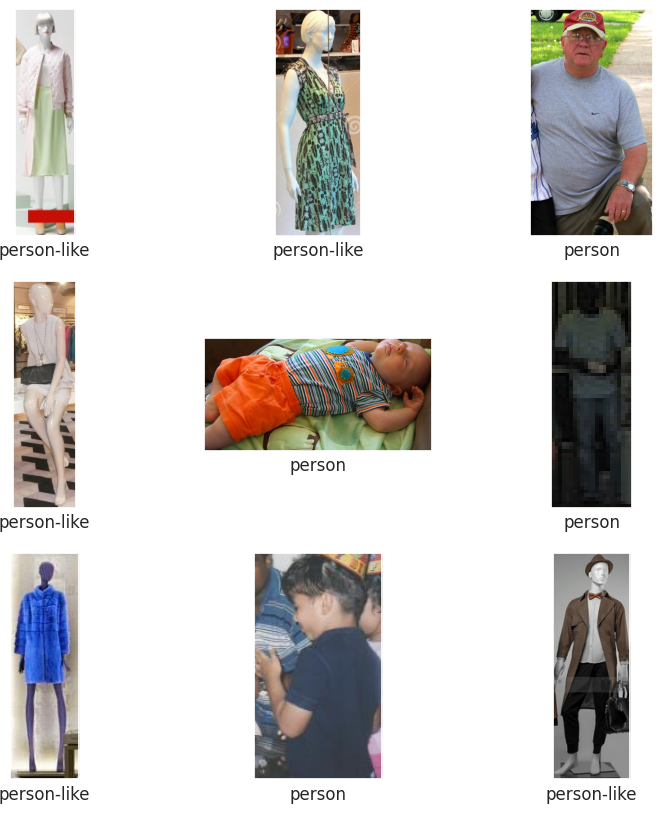

In [26]:
fig=plt.figure(figsize=(10,10))

for i in range (1,10):
    random=np.random.randint(0,len(trainImage))
    plt.subplot(3,3,i)
    plt.imshow(trainImage[random])
    plt.xlabel(trainLabel[random])
    plt.xticks([])
    plt.yticks([])

### Test Data

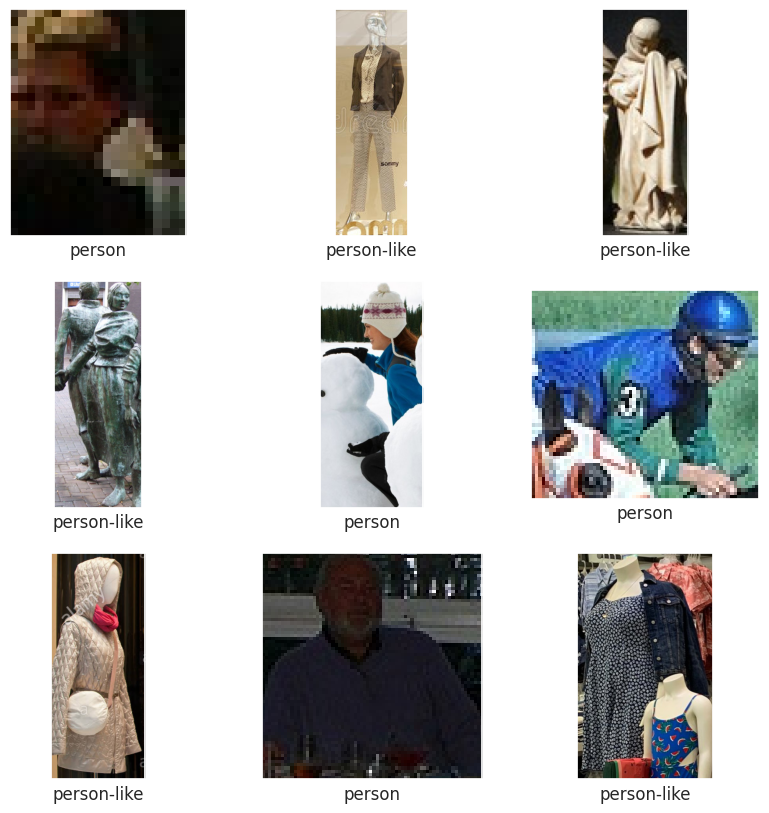

In [27]:
fig=plt.figure(figsize=(10,10))

for i in range (1,10):
    random=np.random.randint(0,len(testImage))
    plt.subplot(3,3,i)
    plt.imshow(testImage[random])
    plt.xlabel(testLabel[random])
    plt.xticks([])
    plt.yticks([])

## YOLO Model Training

In [28]:
yaml_content = """
train: /kaggle/working/yolov8/train
val: /kaggle/working/yolov8/val
test: /kaggle/working/yolov8/test

nc: 2
names: ['person', 'person-like']
"""

yaml_path = '/kaggle/working/pedestrian_detection.yaml'
with open(yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

In [50]:
# Train the model
results = model.train(data=yaml_path, epochs=30, imgsz=640, batch=16)

Ultralytics YOLOv8.2.29 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/pedestrian_detection.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]
2024-06-09 18:28:33,414	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-09 18:28:34,650	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/yolov8/train/labels... 944 images, 0 backgrounds, 0 corrupt: 100%|██████████| 944/944 [00:00<00:00, 1190.45it/s]


train: New cache created: /kaggle/working/yolov8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/yolov8/val/labels... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<00:00, 1105.43it/s]

val: New cache created: /kaggle/working/yolov8/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.35G     0.9984      2.006      1.259         63        640: 100%|██████████| 59/59 [00:15<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        160        333      0.596      0.562      0.602      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.113      1.517      1.343         71        640: 100%|██████████| 59/59 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        160        333      0.564      0.529      0.514      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.209      1.622      1.419         85        640: 100%|██████████| 59/59 [00:11<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

                   all        160        333      0.556      0.452      0.456       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.242      1.579      1.434        111        640: 100%|██████████| 59/59 [00:13<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

                   all        160        333      0.443      0.449      0.371      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.27G      1.217      1.526       1.42         84        640: 100%|██████████| 59/59 [00:11<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]

                   all        160        333      0.656      0.581      0.621      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.189      1.434      1.405         80        640: 100%|██████████| 59/59 [00:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

                   all        160        333      0.657      0.638      0.663      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.29G      1.134      1.368      1.362        108        640: 100%|██████████| 59/59 [00:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]

                   all        160        333      0.628      0.673      0.677      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.29G      1.103      1.306      1.352         86        640: 100%|██████████| 59/59 [00:11<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.45it/s]

                   all        160        333      0.625      0.679      0.666      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.27G      1.083      1.219       1.34         88        640: 100%|██████████| 59/59 [00:12<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]

                   all        160        333      0.705      0.718      0.731       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.29G        1.1      1.211      1.336         66        640: 100%|██████████| 59/59 [00:11<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]

                   all        160        333      0.755      0.645      0.728      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.27G      1.072      1.173       1.32         77        640: 100%|██████████| 59/59 [00:12<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]

                   all        160        333      0.728      0.708      0.726      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.29G      1.039      1.122      1.303         58        640: 100%|██████████| 59/59 [00:11<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]

                   all        160        333      0.727      0.617      0.691      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.27G      1.003       1.09      1.297         70        640: 100%|██████████| 59/59 [00:11<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

                   all        160        333      0.731      0.652        0.7      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.29G     0.9719      1.046      1.252         68        640: 100%|██████████| 59/59 [00:11<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

                   all        160        333      0.633      0.734      0.683      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.29G     0.9679      1.008      1.261         95        640: 100%|██████████| 59/59 [00:11<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

                   all        160        333      0.788       0.78      0.814      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.29G     0.9718      1.017      1.254         62        640: 100%|██████████| 59/59 [00:12<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]

                   all        160        333      0.791      0.767      0.802      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.29G     0.9459     0.9596      1.228         66        640: 100%|██████████| 59/59 [00:11<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]

                   all        160        333      0.761       0.73      0.803      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.28G     0.8928      0.915      1.212         86        640: 100%|██████████| 59/59 [00:12<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.41it/s]

                   all        160        333      0.831      0.792       0.84      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.29G     0.8951     0.9231      1.217         74        640: 100%|██████████| 59/59 [00:11<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

                   all        160        333      0.774      0.676      0.731        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.29G      0.884     0.8979       1.21         60        640: 100%|██████████| 59/59 [00:12<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.29it/s]

                   all        160        333      0.824      0.791      0.863       0.61


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.27G     0.8442     0.8244      1.198         39        640: 100%|██████████| 59/59 [00:12<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]

                   all        160        333      0.823      0.766      0.865      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.25G     0.7852      0.716       1.15         45        640: 100%|██████████| 59/59 [00:11<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

                   all        160        333      0.849       0.77       0.85      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.25G     0.7757     0.6796      1.142         33        640: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]

                   all        160        333      0.816      0.821      0.853      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.16G     0.7562     0.6702      1.121         32        640: 100%|██████████| 59/59 [00:11<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

                   all        160        333       0.89      0.802      0.885      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.25G     0.7381     0.6533       1.11         23        640: 100%|██████████| 59/59 [00:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]

                   all        160        333      0.874      0.806      0.886      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.27G     0.7072     0.6132      1.092         35        640: 100%|██████████| 59/59 [00:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]

                   all        160        333      0.894       0.82      0.892      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.25G     0.7069     0.5928      1.108         46        640: 100%|██████████| 59/59 [00:11<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]

                   all        160        333      0.889      0.833       0.89      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.27G     0.6797     0.5727      1.074         26        640: 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]

                   all        160        333      0.881      0.856      0.892      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.27G      0.655      0.548       1.06         37        640: 100%|██████████| 59/59 [00:11<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

                   all        160        333      0.919       0.83      0.892      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.29G     0.6447     0.5348      1.044         42        640: 100%|██████████| 59/59 [00:11<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all        160        333       0.87      0.825      0.884      0.633



30 epochs completed in 0.121 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.29 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


                   all        160        333      0.918      0.832      0.892      0.642
                person         93        203      0.894      0.748      0.846      0.582
           person-like         76        130      0.942      0.915      0.938      0.703
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg1,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg2,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
metrics/mAP50(B),▄▃▂▁▄▅▅▅▆▆▆▅▅▅▇▇▇▇▆██▇▇███████
metrics/mAP50-95(B),▃▂▁▁▃▄▄▅▄▅▅▅▅▅▆▆▆▇▆▇▇▇▇███████
metrics/precision(B),▃▃▃▁▄▄▄▄▅▆▅▅▅▄▆▆▆▇▆▇▇▇▆█▇██▇██
metrics/recall(B),▃▂▁▁▃▄▅▅▆▄▅▄▄▆▇▆▆▇▅▇▆▇▇▇▇▇████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▅▆███▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁


In [51]:
# Save the best model weights
model.save('/kaggle/working/model.pt')

## Evaluate the Model

In [52]:
# Validate the model
results = model.val(data=yaml_path)

Ultralytics YOLOv8.2.29 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/yolov8/val/labels.cache... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


                   all        160        333      0.926      0.827      0.891      0.642
                person         93        203      0.905      0.747      0.846      0.581
           person-like         76        130      0.947      0.908      0.936      0.704
Speed: 0.2ms preprocess, 14.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2


In [60]:
def perform_inference(model, image):
    # Convert image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image_rgb)
    return results

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1 (list): Bounding box coordinates [x1, y1, x2, y2].
        box2 (list): Bounding box coordinates [x1, y1, x2, y2].

    Returns:
        Float: IoU value between the two bounding boxes.
    """
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate area of each bounding box
    area1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate union area
    union_area = area1 + area2 - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou


def apply_nms(boxes, scores, iou_threshold=0.5):
    boxes = torch.tensor(boxes)
    scores = torch.tensor(scores)
    if len(boxes) == 0:
        return []

    # Sort boxes by their confidence scores
    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)

    keep_indices = []
    while len(sorted_indices) > 0:
        # Pick the box with the highest confidence score
        best_index = sorted_indices[0]
        keep_indices.append(best_index)

        # Calculate IoU with other boxes
        ious = [calculate_iou(boxes[best_index], boxes[idx]) for idx in sorted_indices[1:]]

        # Remove boxes with IoU higher than the threshold
        sorted_indices = [sorted_indices[i + 1] for i, iou in enumerate(ious) if iou <= iou_threshold]

    return keep_indices

def draw_bounding_boxes(image, results, labels, iou_threshold=0.5):
    for r in results:
        annotator = Annotator(image)
        boxes = r.boxes.xyxy.cpu().numpy().astype(int)
        scores = r.boxes.conf.cpu().numpy()
        class_ids = r.boxes.cls.cpu().numpy().astype(int)

        indices = apply_nms(boxes, scores, iou_threshold)
        
        for idx in indices:
            b = boxes[idx]
            c = class_ids[idx]
            annotator.box_label(b, labels[int(c)])
        
        image_with_boxes = annotator.result()
    return image_with_boxes

def display_predictions():
    # Labels for your classes (example)
    labels = ['person', 'person-like']
    fig = plt.figure(figsize=(15, 15))
    image_dir = os.path.join(test_dest, 'images')
    
    for index in range(9):
        image = cv2.imread(os.path.join(image_dir, f'image ({np.random.randint(200)}).jpg'))
        results = perform_inference(model, image)
        image_with_boxes = draw_bounding_boxes(image, results, labels)
        
        plt.subplot(3, 3, index+1)
        plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
        plt.xticks([])
        plt.yticks([])
    
    plt.show()


0: 512x640 1 person, 70.3ms
Speed: 4.5ms preprocess, 70.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 6 person-likes, 64.8ms
Speed: 4.5ms preprocess, 64.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 1 person, 1 person-like, 67.8ms
Speed: 3.3ms preprocess, 67.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 2 persons, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6.2ms
Speed: 2.5ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 persons, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.2ms postprocess per image at

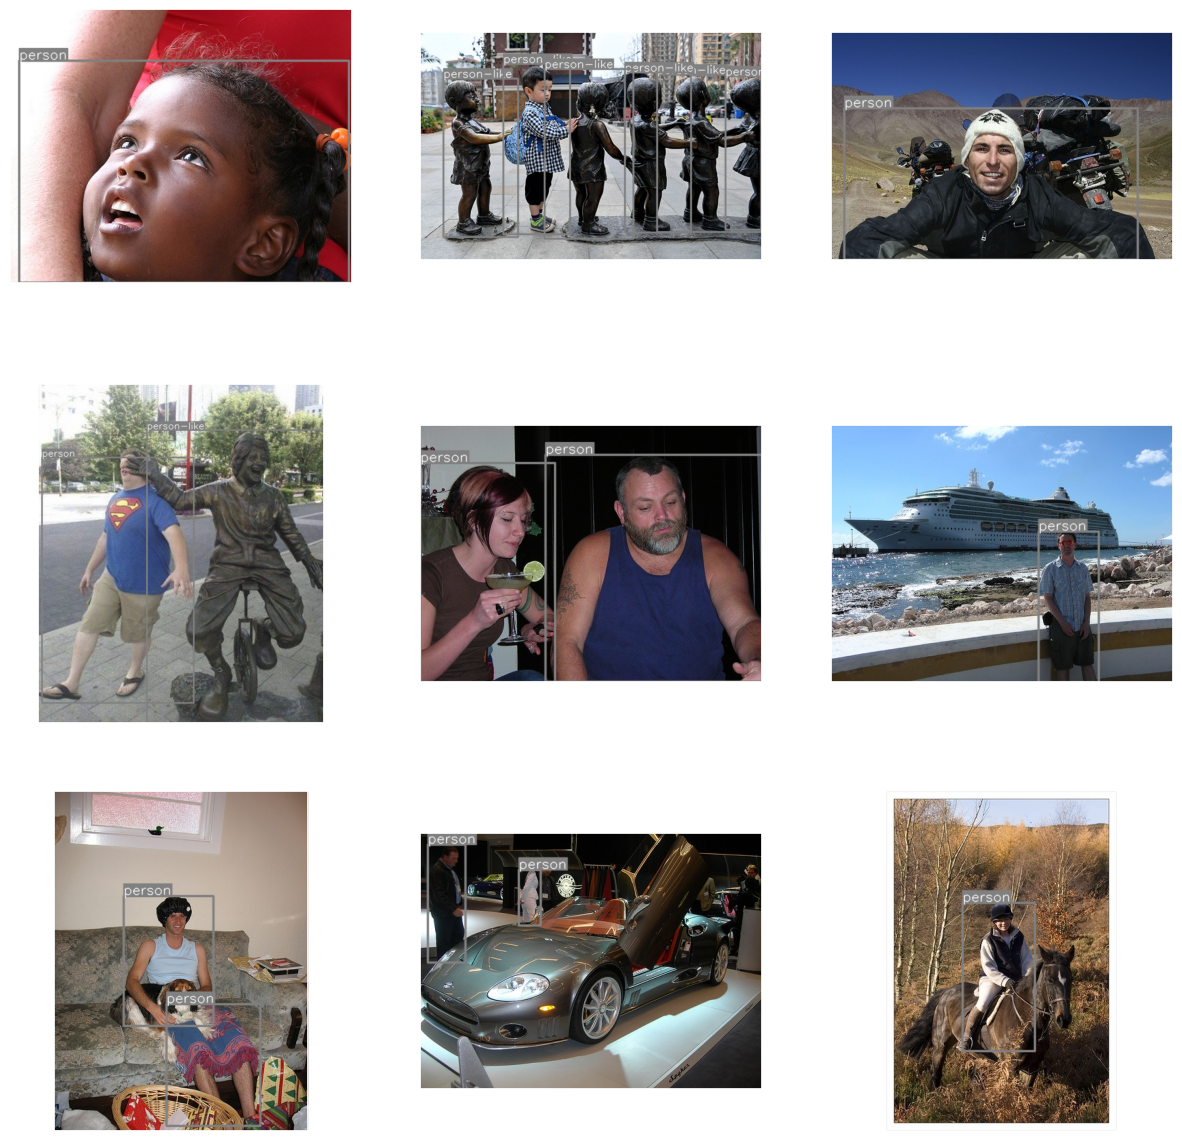

In [61]:
display_predictions()